# Lab 3: The DFT and Sampling
## Due Date: 7/6 @ 11:59pm on Compass

In the last lab, we explored the Discrete-Time Fourier Transform (DTFT) and the frequency response of LSI systems. However, we know that it is impossible to hold an entire DTFT in computer memory since the DTFT of a signal has infinitely many points! We will discuss the Discrete Fourier Transform (DFT) and Fast Fourier Transform (FFT) in this lab as the practical implementations of the DTFT and consider some of the limitations and considerations when using the DFT.

## Discrete Fourier Transform

The Discrete Fourier Transform (DFT) is the discretized version of the DTFT. Sounds weird, right? Isn't the DTFT already discrete? It's in the name! But recall that the DTFT is a continuous function: it has infinitely many points to represent frequency content from $-\pi$ to $\pi$. The DFT is just a resampling of the DTFT. In other words, the DFT picks a finite number of equally spaced points in the DTFT for representation.

More concretely, the DFT is computed as follows: 

$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j\frac{2\pi k}{N}n}, \quad 0\leq k\leq N-1.
$$
And the inverse DFT is given by:

$$
x[n] = \frac{1}{N}\sum_{k=0}^{N-1}X[k]e^{j\frac{2\pi k}{N}n}, \quad 0\leq n\leq N-1
$$
The DFT has $N$ "frequency bins" differentiated by our frequency index $k$. These are the samples we take from the DTFT. Perhaps a more intuitive formulation with respect to the DTFT makes these bins more obvious:

$$
\omega_k = \frac{2\pi k}{N},
$$

$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j\omega_k n}, \quad 0\leq k\leq N-1.
$$

This representation explicitly shows that we try to capture $N$ equally spaced frequencies between 0 to $2\pi$ (same as $-\pi$ to $\pi$ by periodicity of DTFT) with the DFT.

### The Linear Algebra Intuition

The DFT gives an important insight into how we can use linear algebra or vectorize our systems to perform common signal processing operations. Consider our second formulation of the DFT. Suppose we fix $k$ to be one value $k_0$. The second formulation tells us that

$$
X[k_0] = \sum_{n=0}^{N-1}x[n]e^{-j\omega_{k_0} n}.
$$

There is helpful notation that can be introduced here using something call the "twiddle factor" (great name, right?). Different conventions exist for the twiddle factor, but we will opt for the one most consistent with your ECE 310 textbook. Consider the following notation for the twiddle factor $W$:

$$
W = e^{-j2\pi}
$$

$$
W_N = e^{-j\frac{2\pi}{N}}
$$

$$
W_N^{k} = e^{-j\frac{2\pi k}{N}}
$$

If we return to our expression for $X[k_0]$, we see that all we are doing at frequency $\omega_{k_0}$ is summing the product of each entry in the signal and some complex exponential. This is the same thing as taking an inner product (dot product) between the signal and the complex exponential rotating at frequency $w_{k_0}$! Thus,

$$
e^{-j\omega_{k_0}n} = [e^{-j\omega_{k_0}*(0)},e^{-j\omega_{k_0}*(1)},\ldots,e^{-j\omega_{k_0}*(N-1)}] = [W_N^{k_0*0},W_N^{k_0*1},W_N^{k_0*2},\ldots,W_N^{k_0*(N-1)}]
$$

$$
X[k_0] = \langle W_N^{-k_0n},x[n] \rangle = \sum_{n=0}^{N-1}x[n]e^{-j\omega_{k_0} n}.
$$

Note that when we take the inner product over complex numbers, we conjugate-transpose the first term by convention. For example, $\langle x,y\rangle = x^*y$, where $x^*$ is the transpose of $x$ and each element is complex conjugated. Thus,
$$
X[k_0] = \langle W_N^{-k_0n},x[n] \rangle = \sum_{i=0}^{N-1}W_N^{k_0i}x[i]
$$
as desired.

Now, recall that if the dot product between two vectors is large, they are similar. The same is true here! For each frequency, we take the dot product between our signal and a vector represented by a complex exponential rotating at a fixed frquency. The result tells us how much that fixed frequency is found in our signal. Wow. We can take one final step to make the entire DFT a matrix-vector product:

$$
X[k] = \mathbf{W}\vec{x}
$$

$$
X[k] = \underbrace{\begin{bmatrix}
W_N^0 & W_N^0 & \cdots & W_N^0 \\
W_N^0 & W_N^1 & \cdots & W_N^{N-1}\\
\vdots &  \vdots & \ddots & \vdots\\
W_N^0 & W_N^{N-1} & \cdots & W_N^{(N-1)(N-1)}
\end{bmatrix}}_{\mathbf{W}}
\underbrace{\begin{bmatrix}
x[0] \\
x[1] \\
\vdots \\
x[N-1] \\
\end{bmatrix}}_{\vec{x}} = 
\begin{bmatrix}
\langle W_N^{-0*n},\vec{x} \rangle\\
\langle W_N^{-1*n},\vec{x} \rangle\\
\vdots\\
\langle W_N^{-k*n},\vec{x} \rangle\\
\vdots\\
\langle W_N^{-(N-1)*n},\vec{x} \rangle\\
\end{bmatrix}
$$

In the above $\textbf{W}$ matrix, each row represents a frequency vector rotating at a certain frequency. More concretely, row $k$ in $\mathbf{W}$ represents the frequency vector rotating with frequency $\omega_k=\frac{2\pi}{N}k$. This kind of intuition is powerful in signal processing. If this confuses or (hopefully not) scares you, do not worry! It takes time to be comfortable with combining signal processing and linear algebra. Read the above explanation a couple times, ask your TA questions, check out your textbook's coverage of this, or hang out with some friends and chat about it!

### And finally the FFT!

We will not focus on the math of the FFT since you have covered it in ECE 310. For now, we should acknowledge the computational efficiency of the FFT. The previous two views of the DFT we have discussed - summation and vectorized versions - all require $\mathcal{O}(n^2)$ multiply-add operations. Conversely, the FFT is a divide-and-conquer algorithm that can perform the same computation in $\mathcal{O}(n\log n)$ multiply-add operations. Keep this in mind when completing Excercise 1.

In [10]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio
from skimage.io import imread
from scipy import signal
from scipy.io import wavfile

%matplotlib inline

## Excercise 1: Implementing the DFT

There are multiple different implementations we can use to represent the DFT. In this exercise, you will compare three ways to compute the DFT. 

a. First, fill in the below function $\textrm{dfl_dft()}$ to create a double for-loop implementation of the DFT. Hint: this will work a lot like your DTFT function from Lab 4!

b. Next, fill in $\textrm{dft_matrix()}$ and $\textrm{vectorized_dft()}$ to create a vectorized implementation of the DFT.

c. Finally, let's test our double for-loop and vectorized methods against the $\textrm{np.fft.fft()}$ implementation. Run the provided code that benchmarks the running time of eahc method and verifies if your methods accurately compute the DFT of a randomly generated signal. Note that we do not benchmark the time to build the $\mathbf{W}$ matrix since this could be precomputed in a practical context. For example, if we compute 1000 length-500 DFTs, we would only need to construct "W" once. Comment on the results. Which method is fastest? Slowest? Why? Does anything surprise you?

In [17]:
#Function to complete for 1.a
def dfl_dft(x):
    N = len(x)
    dft = np.zeros(N, dtype=np.complex64)
    #for loop to iterate over 'k'
    for k in range(N):
    #for loop to iterate over 'n'
        for n in range(N):
            dft[k] += x[n]*np.exp(-1j*(2*np.pi*k/N)*n) 
            #N = number of samples
            #k = second iteration
    return dft

#Functions to complete for 1.b
#Construct the matrix W
def dft_matrix(N):
    W = np.zeros((N, N),dtype=np.complex64)
    #fill in W however you see fit!
    for a in range(N):
        for b in range(N):
            W[a][b] = np.exp(-1j*2*np.pi*a*b/N)
    return W
#Take the DFT of signal x using the matrix W
def vectorized_dft(W, x):
    #this should only take one line...
    #refer to the above math if you are unsure!
    dft = W @ x
    return dft

In [18]:
#Provided code for 1.c
#Generate test signal
N = 500
x = np.random.uniform(size=N)

#Test double for-loop implementation
print('Double For Loop Time:')
%timeit dfl_dft(x)
print('')

#Test vectorized implementation
#don't time W matrix construction since this is precomputation that could be practically stored
W = dft_matrix(N)
print('Vectorized Time')
%timeit vectorized_dft(W,x)
print('')

#Test numpy's fft implementation
print('Numpy Time')
%timeit np.fft.fft(x)
print('')

#Test if results are equivalent
print('Double for-loop and numpy fft are equivalent:',np.allclose(dfl_dft(x),np.fft.fft(x)))
print('Vectorized DFT and numpy fft are equivalent:',np.allclose(vectorized_dft(W,x),np.fft.fft(x)))

Double For Loop Time:
1.46 s ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Vectorized Time
336 µs ± 34.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Numpy Time
10.2 µs ± 960 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Double for-loop and numpy fft are equivalent: True
Vectorized DFT and numpy fft are equivalent: True


Answer for Part 1.c:

Seems like the numpy fourier transform was the fastest way. It beat the double for loop time (the slowest method) by 10^6 times, and this is because the runtime of the numpy version was *O(nlog(n))* and the other two methods have a runtime of *O(n^2))*. However, even though the double for loop and vectorized time have the same runtime, only the upper-bound is specified, so the values could be anywhere from zero to the upper-bound. 


## Windowing and Zero-Padding

We will now briefly discuss the motivation for windowing and zero-padding. Exercises 2 and 3 will demonstrate and reinforce this theory.

Recall that the DFT works under the practical assumption that we only have a finite number of samples for our signal. Unlike the DTFT which uses infinitely points, we must use a finite collection to capture the frequency content of our signal. In the simplest case, we use a rectangular window that removes the $N$ points of our signal we would like to inspect for the DFT. Mathematically, we have,

$$
x_{\textrm{windowed}} = x[n](u[n-n_0]-u[n-(n_0+N)]),
$$

where $n_0$ is the start-point of our signal's window. This window signal is the same as a shifted rectangle function. We see that windowing is multiplying in the time domain, which by convolution theory must correspond to multiplication in the frequency domain. Thus, for a window function $w[n]$,

$$
x[n]w[n] \stackrel{\mathcal{F}}{\leftrightarrow} \frac{1}{2\pi}X(\omega) * W(\omega).
$$

Exercise 2 will explore the consequences of using the rectangular window and what other windows may be used. Next, let's explain the use of zero-padding. When zero-padding a signal, we are simply appending some number of zeros to the end of the original signal. What effect does this have? Suppose I have original signal $x[n]$ of length $N$ and a zero-padded signal $x_{zp}[n]$ of length $M>N$ that has been padded with $M-N$ zeros.

\begin{align*}
X[k] &= \sum_{n=0}^{N-1}x[n]e^{-j\frac{2\pi k}{N}n},\quad 0\leq k\leq N-1
\\X_{zp}[k] &= \sum_{n=0}^{M-1}x_{zp}[n]e^{-j\frac{2\pi k}{M}n},\quad 0\leq k\leq M-1
\\x_{zp}[n] = 0\textrm{ for all } n \geq N \implies X_{zp}[k] &= \sum_{n=0}^{N-1}x_{zp}[n]e^{-j\frac{2\pi k}{M}n}
\\X_{zp}[k] &= \sum_{n=0}^{N-1}x[n]e^{-j\frac{2\pi k}{M}n},\quad 0\leq n\leq M-1
\end{align*}
We see that the zero-padded signal's DFT will use the exact same signal values, and thus have the exact same frequency content. The difference is that the spacing of our frequency sampling is tighter!

$$
\frac{2\pi}{M} < \frac{2\pi}{N}
$$

Consequently, we add no "information" to our signal (only zeros) and gain higher frequency resolution at the cost of storing some zeros. This is what implictly happens when you use $\textrm{np.fft.fft()}$ or $\textrm{np.fft.rfft()}$ and specify a number of points greater than the length of the signal. Exercise 3 will give a brief example of how zero-padding can affect our ability to resolve different frequency components or notes in audio.

## Excercise 2: Windowing Effects

In this exercise, we want to investigate the effects of different windowing methods. When we are computing the DFT of a finite-length signal, it is implied that there is periodic extension of this finite segment. If the segment precisely captures full cycles of all the frequencies, then there will be no problem since we have no periodic interruptions and the transition between periodic copies of the signal will be seamless. However, if the segment does not capture full cycles of some frequencies, then there will be periodic interruptions or discontinuities as the signal is periodically extended. This can lead to changes in our ideal frequency content. This problem is referred to as spectral leakage. This is illustrated in the example below:

Suppose that we are sampling a single sine wave, consider the two cases we have discussed:
1. We sample a window of the signal that perfectly captures an integer number of signal periods.
2. We sample a window of the signal that captures a fractional number of signal periods.

Below, our ideal signal is $\sin\left(\frac{\pi}{4}n\right)$. Thus, we need eight points to capture a full period of the signal.

Text(0.5, 0, '$\\omega$')

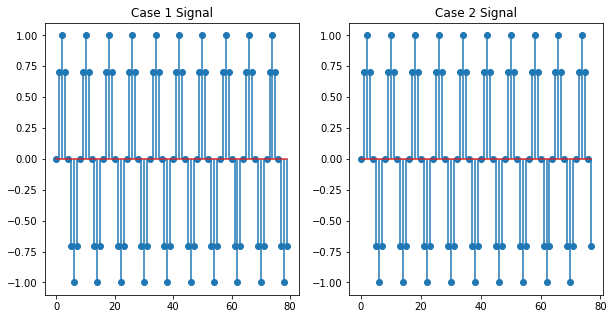

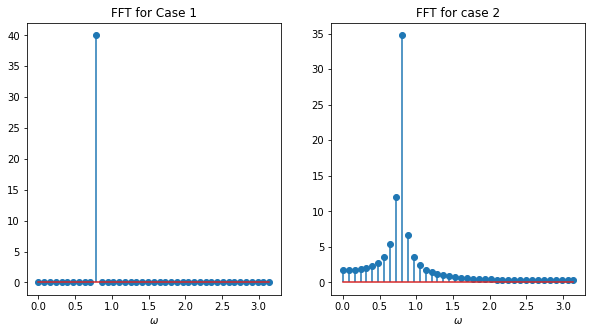

In [19]:
#Make longer signal that we will window in order to analyze a smaller portion
x = np.array([np.sin(np.pi/4*n) for n in range(200)])
# Case 1 
N1 = 80 #10 full periods
x1 = x[:N1]
x1_fft = np.fft.rfft(x1)
omega_1 = np.linspace(0,np.pi,len(x1_fft))

# case 2
N2 = 78 # 7 full period and one fractional period
x2 = x[:N2]
x2_fft = np.fft.rfft(x2)
omega_2 = np.linspace(0,np.pi,len(x2_fft))

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.stem(x1)
plt.title('Case 1 Signal')
plt.subplot(122)
plt.stem(x2)
plt.title('Case 2 Signal')

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.stem(omega_1, abs(x1_fft))
plt.title('FFT for Case 1')
plt.xlabel('$\omega$')
plt.subplot(122)
plt.stem(omega_2, abs(x2_fft))
plt.title('FFT for case 2')
plt.xlabel('$\omega$')

From the above example, we can see that although we are sampling the same sine wave signal, we obtain different frequency spectra for the two cases. The mismatch in sampling length for case 2 leads to the spectral leakage witnessed above. Notice how the main peak at $\frac{\pi}{4}$ is lower in case 2 since the energy of this frequency has spread out to adjacent frequencies. Recall that the mismatch in sampling size creates a discontinuity between the periodically extended copies of our finite window. This introduces other frequencies into the spectrum to compensate for this discontinuity. In practice, spectral leakage is unavoidable since many real-world signals have much richer frequency content. This is where windowing comes in.

We would like windowing to smooth out the discontinuity and decrease the impact of spectral leakage. There are a many possible windows we may consider, but we will restrict ourselves to examining the following three:

1. Rectangular or Boxcar Window
2. Hamming Window
3. Kaiser ($\beta=3$)

a. Plot the time domain representation of each of these windows (using the ``N2=78`` from above). Hint: use $\textrm{scipy.signal.hamming()}$ and $\textrm{scipy.signal.kaiser()}$.

b. Plot the magnitude spectrum of each window on the same plot on a dB scale. **Please specify 512 points and use $\textrm{np.fft.rfft()}$**. You may use $\textrm{plt.plot()}$ instead of $\textrm{plt.stem()}$ since we have many points here. We have provided a function $\textrm{sig2db}$ that converts a magnitude response to dB scale. Comment on the differences in the magnitude spectrum of each window.

c. Apply each window to the sine wave signal we sampled with a fractional number of periods (``x2``) and plot the magnitude spectrum of each windowed result. Comment on the resulting spectra. How do the main lobe widths and side lobe heights of the sinusoid's peak differ?

<ipython-input-32-8bb8affa7803>:5: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(mag_spec)


Text(0.5, 1.0, 'Kaiser Signal DFT')

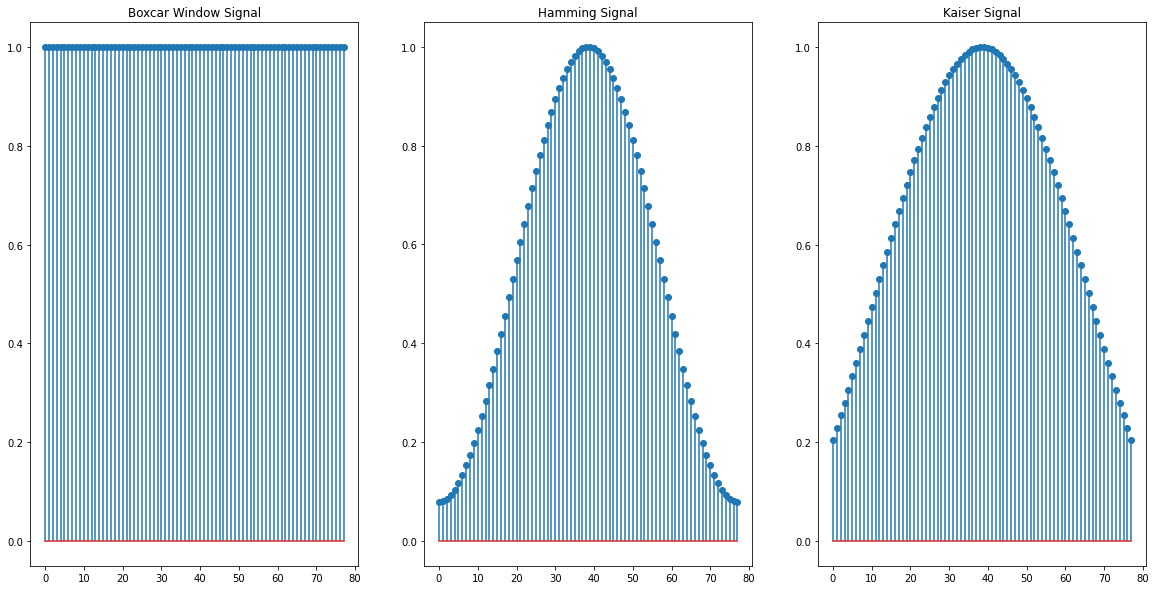

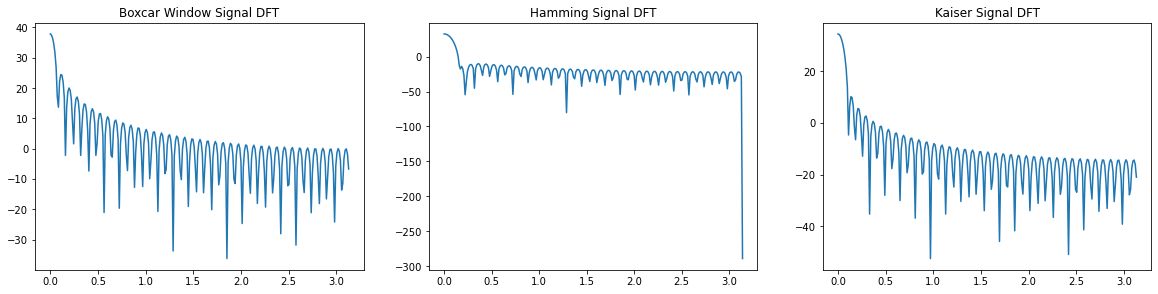

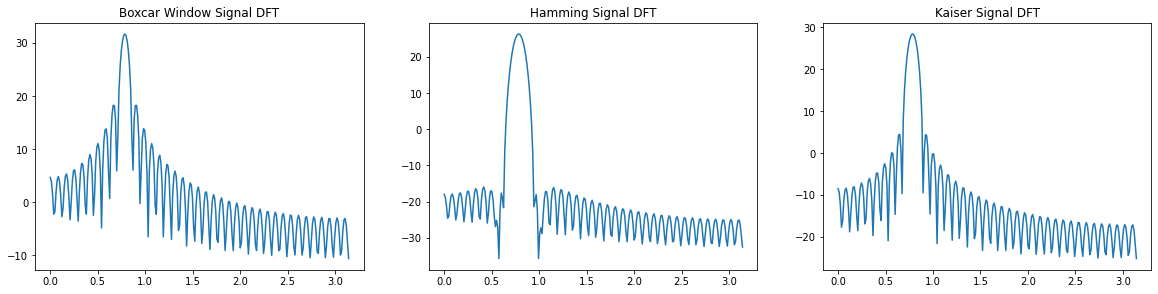

In [32]:
N2 = 78 # number of points we use to create our window
x2 = x[:N2]
# quick function for converting a magnitude response to dB
def sig2db(mag_spec):
    return 20*np.log10(mag_spec)


#Code for 2.a:
boxcar = [1]*N2
hamming = signal.hamming(N2)
kaiser = signal.kaiser(N2,3)

plt.figure(figsize=(20,10))

plt.subplot(131)
plt.stem(boxcar)
plt.title('Boxcar Window Signal')

plt.subplot(132)
plt.stem(hamming)
plt.title('Hamming Signal')

plt.subplot(133)
plt.stem(kaiser)
plt.title('Kaiser Signal')

#Code for 2.b
boxcarFFT = np.fft.rfft(boxcar,512)
boxcarXvalues = np.linspace(0,np.pi, len(boxcarFFT))
boxcarDecibal = sig2db(np.absolute(boxcarFFT))

hammingFFT = np.fft.rfft(hamming,512)
hammingXvalues = np.linspace(0,np.pi, len(hammingFFT))
hammingDecibal = sig2db(np.absolute(hammingFFT))

kaiserFFT = np.fft.rfft(kaiser,512)
kaiserXvalues = np.linspace(0,np.pi, len(kaiserFFT))
kaiserDecibal = sig2db(np.absolute(kaiserFFT))

plt.figure(figsize=(20,10))

plt.subplot(231)
plt.plot(boxcarXvalues, boxcarDecibal)
plt.title('Boxcar Window Signal DFT')

plt.subplot(232)
plt.plot(hammingXvalues, hammingDecibal)
plt.title('Hamming Signal DFT')

plt.subplot(233)
plt.plot(kaiserXvalues, kaiserDecibal)
plt.title('Kaiser Signal DFT')
#Code for 2.c:
boxcarX2  = boxcar*x2
hammingX2 = hamming*x2
kaiserX2 = kaiser*x2

boxcarFFT = np.fft.rfft(boxcarX2,512)
boxcarXvalues = np.linspace(0,np.pi, len(boxcarFFT))
boxcarDecibal = sig2db(np.absolute(boxcarFFT))

hammingFFT = np.fft.rfft(hammingX2,512)
hammingXvalues = np.linspace(0,np.pi, len(hammingFFT))
hammingDecibal = sig2db(np.absolute(hammingFFT))

kaiserFFT = np.fft.rfft(kaiserX2,512)
kaiserXvalues = np.linspace(0,np.pi, len(kaiserFFT))
kaiserDecibal = sig2db(np.absolute(kaiserFFT))

plt.figure(figsize=(20,10))

plt.subplot(231)
plt.plot(boxcarXvalues, boxcarDecibal)
plt.title('Boxcar Window Signal DFT')

plt.subplot(232)
plt.plot(hammingXvalues, hammingDecibal)
plt.title('Hamming Signal DFT')

plt.subplot(233)
plt.plot(kaiserXvalues, kaiserDecibal)
plt.title('Kaiser Signal DFT')

Comments for part 2.b: The boxcar window has much larger magnitudes (~40 db - largest peak) compared to the hamming and Kaiser ones. 

Comments for part 2.c: The boxcar has the smallest width on its main peak compared to the other two. The Kaiser signal had a larger width than Boxcar but not as big as Hamming signal. The smaller peaks to the side are taller and closer to the peak, unlike the hamming and kaiser signals. The hamming signal's side lobes also are much shorter compared to the other two graphs. It seems that the boxcar signal is on one end and the hamming on the other, with the kaiser right in the middle. 



## Exercise 3: Zero-Padding00000

Now let's consider the problem of examining frequency content in a piece of music and how zero-padding affects our ability to do so. Load and listen to the below audio clip.

In [44]:
fs, music_stereo = wavfile.read('Hallelujah_16k.wav') # Import the sound file
music_mono = music_stereo[:,0] # To obtain mono sound track
Audio(music_mono, rate = fs)

<ipython-input-44-408e70d90c3e>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, music_stereo = wavfile.read('Hallelujah_16k.wav') # Import the sound file


There's a lot going on for such a short audio clip! What if we only look at the frequency content present in the first 256 samples?

Text(0, 0.5, 'Magnitude Response')

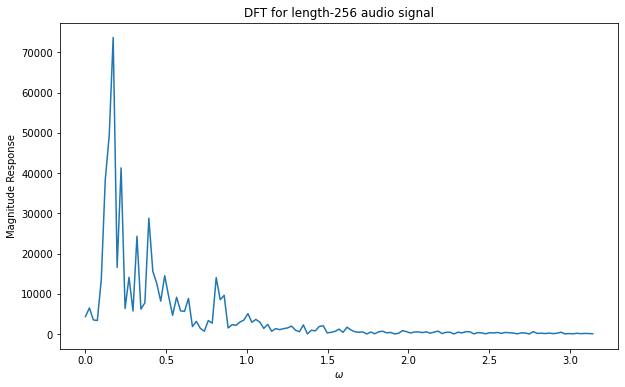

In [45]:
N = 256
music_mono_short = music_mono[:N] # if we are only given the first 256 samples
fft_short = np.fft.rfft(music_mono_short)
omega = np.linspace(0,np.pi,len(fft_short)) 
plt.figure(figsize =(10,6))
plt.plot(omega, abs(fft_short))
plt.title('DFT for length-256 audio signal')
plt.xlabel(r'$\omega$')
plt.ylabel('Magnitude Response')

a. Zero-pad our length-256 clip to length 2048. Plot the new magnitude spectrum of our zero-padded signal.

b. Comment on the differences (quantitative or qualitative) that you observe. Has zero-padding improved our ability to distinguish different frequencies?

c. Now, if we are only given the first 16 samples instead of 256. Do you think zero-padding to length 2048 will also give us the ability to identify all the peaks like in the previous case? Why or why not?

Text(0, 0.5, 'Magnitude')

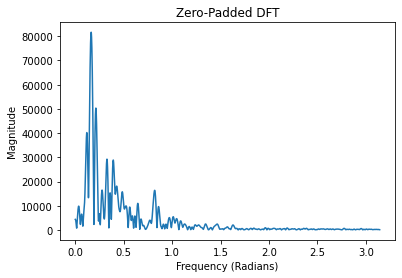

In [46]:
# Code for 3a:

zeropad = np.zeros(20148-len(music_mono_short))
zeropadFFT = abs(np.fft.rfft(np.append(music_mono_short, zeropad)))
zeropadXvalues = np.linspace(0,np.pi,len(zeropadFFT))

plt.plot(zeropadXvalues, zeropadFFT)
plt.title('Zero-Padded DFT')
plt.xlabel('Frequency (Radians)')
plt.ylabel('Magnitude')

Comments for 3b: Zero padding increases the resolution of the sample, bringing it to 80,000 Hz peak. It also has more distinct peaks and troughs for the graph, meaning its more precise and it makes it easier to recognize certain frequencies. 


Comments for 3c: 16 samples would cover the beginning of the signal, since the zero padding is giving more resolution at the beginning and can't uncover peaks after 16 samples. 



## Exercise 4: Spectrograms

Now let's look at the spectrogram for an audio signal. A spectrogram can be thought of as a two-dimensional signal with both time and frequency axes. Thus, the value of a spectrogram at a particular pair of time and frequency indicates how much energy we have of that frequency at the given time. Let visualize some examples to make this more concrete. Specifically, we have three audio files that contain three different speech sounds or utterances.

* Vowel "a": specifically, we hear the sound "ah"
* Consonant "r": speaker repeats the sound "rah"
* Constant "b": speaker repeats the sound "bah"

Let's listen to them and visualize their spectrograms!

In [47]:
fs_a, vowel_a = wavfile.read('a.wav') 
fs_r, cons_r = wavfile.read('r.wav') 
fs_b, cons_b = wavfile.read('b.wav') 

In [48]:
Audio(vowel_a, rate = fs_a)

In [49]:
Audio(cons_r, rate = fs_r)

In [50]:
Audio(cons_b, rate = fs_b)

<ipython-input-51-ddb73479ea87>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_a, f_a, sig2db(S_a))
<ipython-input-51-ddb73479ea87>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_r, f_r, sig2db(S_r))
<ipython-input-51-ddb73479ea87>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass sh

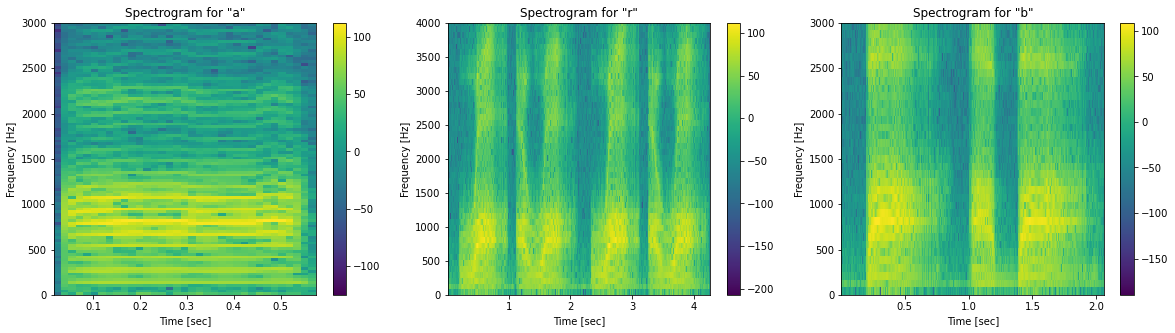

In [51]:
nfft = 512
f_a, t_a, S_a = signal.spectrogram(vowel_a, fs_a, nperseg = nfft, noverlap = int(nfft/2), nfft = nfft)
f_r, t_r, S_r = signal.spectrogram(cons_r, fs_r, nperseg = nfft, noverlap = int(nfft/2), nfft = nfft)
f_b, t_b, S_b = signal.spectrogram(cons_b, fs_b, nperseg = nfft, noverlap = int(nfft/2), nfft = nfft)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.pcolormesh(t_a, f_a, sig2db(S_a))
plt.title('Spectrogram for "a"')
plt.ylim([0, 3000])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.subplot(132)
plt.pcolormesh(t_r, f_r, sig2db(S_r))
plt.title('Spectrogram for "r"')
plt.ylim([0, 4000])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.subplot(133)
plt.pcolormesh(t_b, f_b, sig2db(S_b))
plt.title('Spectrogram for "b"')
plt.ylim([0, 3000])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()

a. Comment on the differences in the the above spectrograms. Which utterances have higher frequency content? Which have lower frequency content? Try thinking about the pitch of your voice when forming these sounds. Remember that the "r" and "b" clips both have the "ah" sound of the first clip, so some frequency content will be shared between all three clips

b. We have included a sound file ``robot.wav`` in the lab folder. This file contains a person saying the word "robot". Load the sound file and plot its spectrogram. Refer to the above spectrogram examples and the $\textrm{signal.spectrogram()}$ documentation if you are unsure how to do this.

c. We know that this word contains the two consonants "r" and "b". From the example spectrograms provided above, can you tell where these consonants appear in the word's spectrogram (i.e. what time do they start)? If so, where do the consonants "r" and "b" begin?

<ipython-input-32-8bb8affa7803>:5: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(mag_spec)
<ipython-input-52-4ca15e97612a>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_a,f_a,sig2db(S_a))


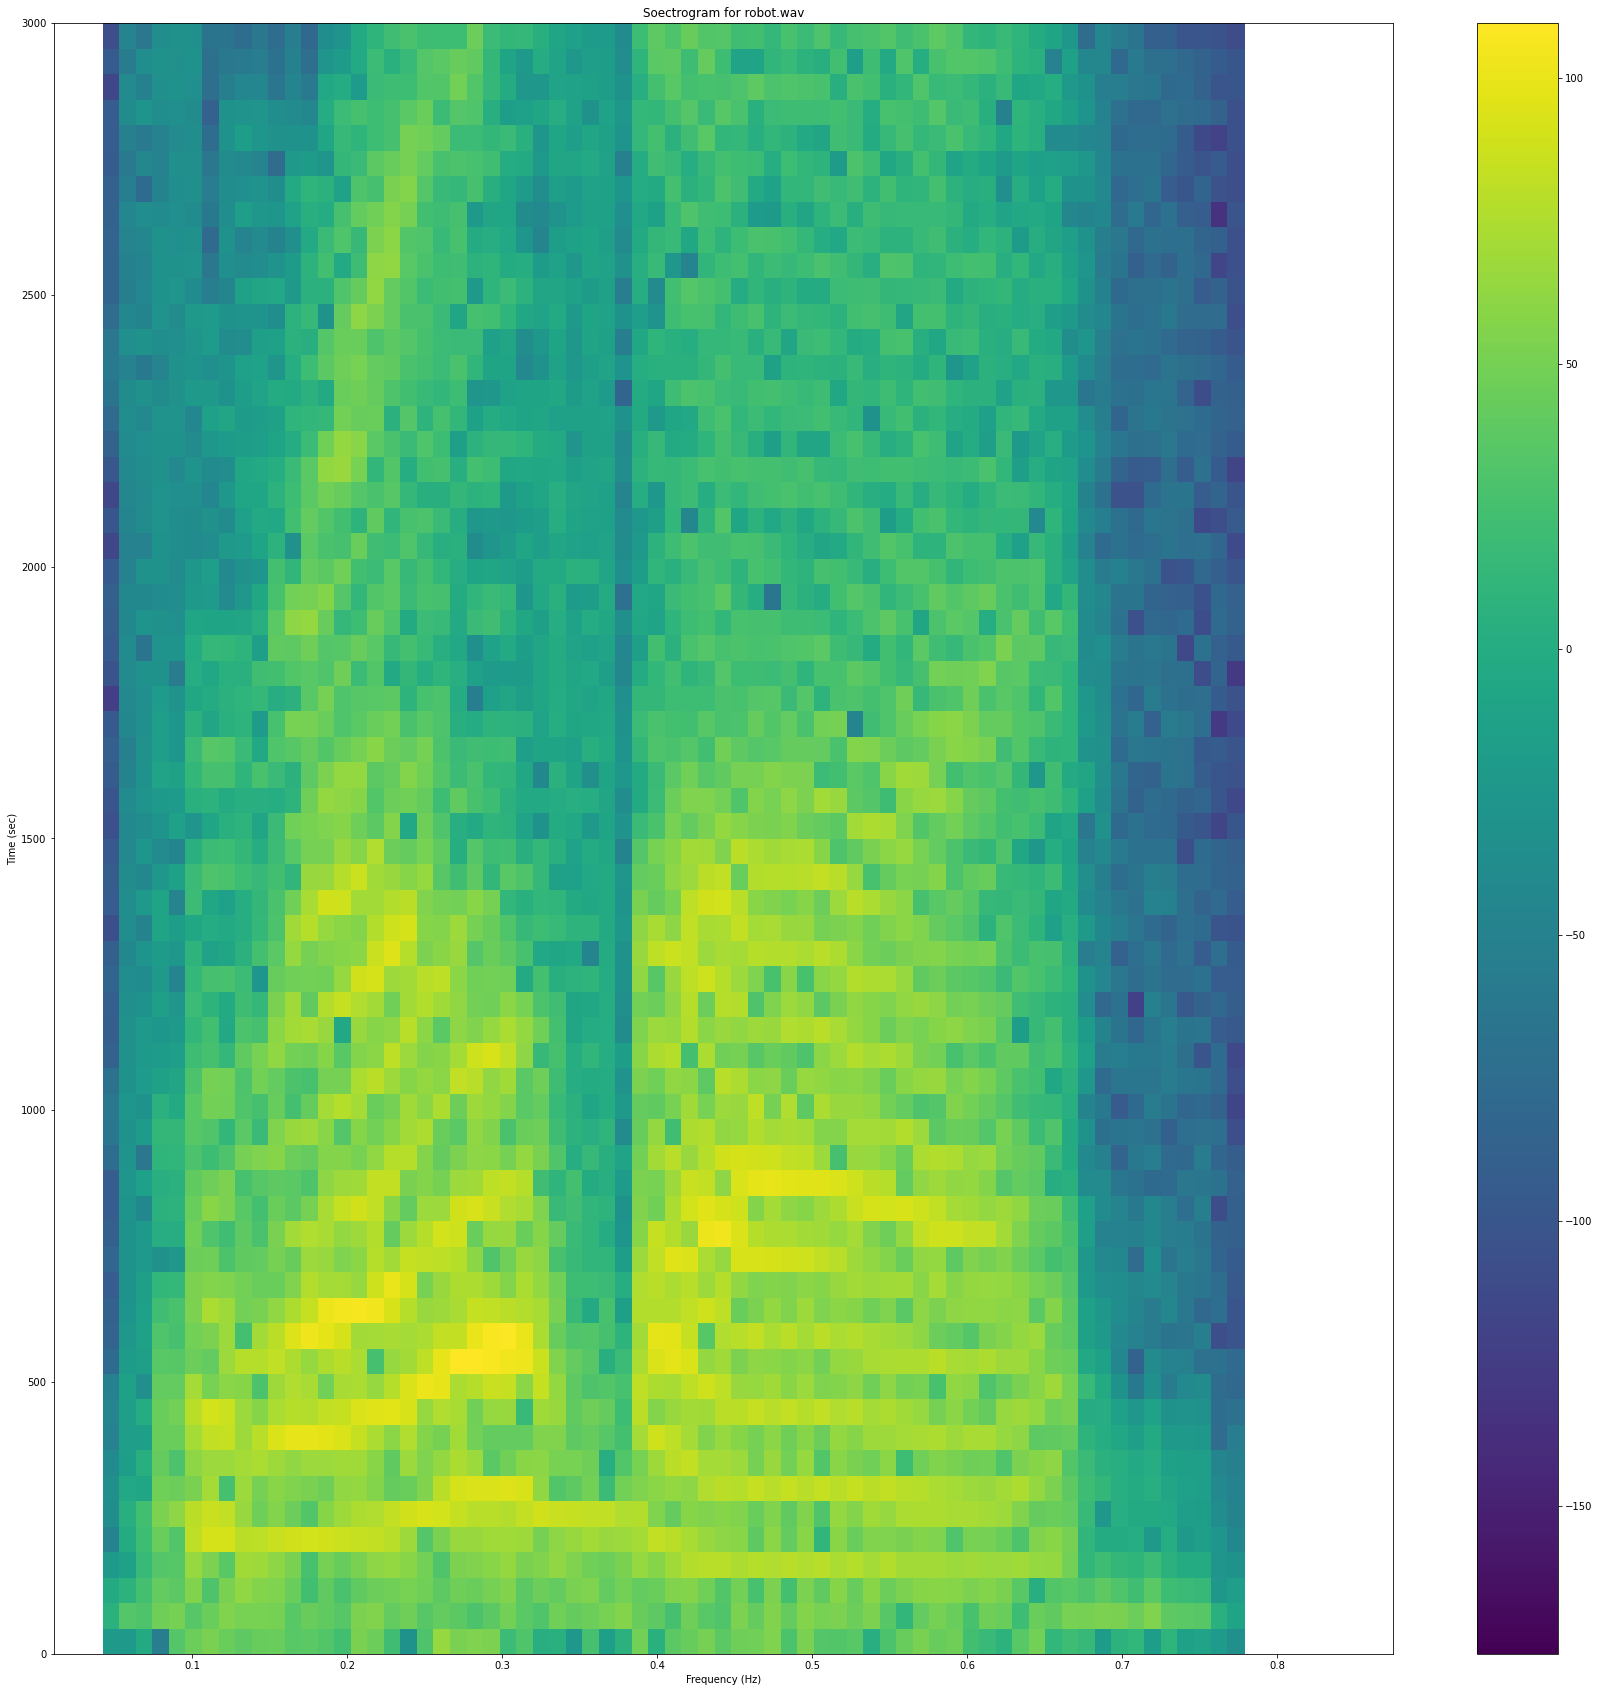

In [52]:
#Code for 4.b here:

fs_a, vowel_a = wavfile.read('robot.wav')
nfft = 512
f_a, t_a, S_a = signal.spectrogram(vowel_a, fs_a, nperseg = nfft, noverlap = int(nfft/2), nfft = nfft)

plt.figure(figsize=(30,30))
plt.pcolormesh(t_a,f_a,sig2db(S_a))
plt.title('Soectrogram for robot.wav')
plt.ylim([0,3000])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Time (sec)')
plt.colorbar()

Comments for 4.a here: The ah produces lower frequencies while b and r have both higher and lower frequencies.



Comments for 4.c here: The r appears at the start of the signal (~0.3s) and b is present from 0.5s to 0.7s.



## Exercise 5: It's a bird! It's a plane! No, it's just aliasing!

We will now get some hands-on experience with aliasing and sampling effects. Python has a helpful function in the ``scipy.signal`` package called $\textrm{signal.chirp()}$ that generates a swept cosine signal. This means we can create a sweeping tone between a start and end frequency. Unfortunately, the documentation for this function is a bit confusing, so let's briefly demonstrate its usage:

In [72]:
Fs = 44100 #sampling rate for audio clip in Hz
t1 = 5 #make clips 5 seconds
t = np.linspace(0,t1,t1*Fs) #make sure to specify the number of points to match desired sampling frequency!!!
f0 = 0 #start frequency (Hz)
f1 = 22050 #end frequency (Hz)

"""
instantanous frequency, f(t) = f0 + (f1-f0)*(t/t1)
"""

chirp_original = signal.chirp(t, f0 = f0, t1 = t1, f1 = f1)

In [73]:
#BE CAREFUL WITH YOUR VOLUME! CHIRP SEQUENCES CAN BE LOUD!

Audio(data = chirp_original,rate = Fs) #give it a listen

We will now inspect the signals we create and try changing the sampling rate.  Once again, be careful when listening to audio.

a. Plot the magnitude of the DTFT of the ``chirp_original`` signal. Plot your frequency axis in digital frequency (0 to $\pi$). What is the maximum frequency our sound card can represent for the sampling frequency used to generate this signal?

b. Generate a second chirp with a sampling frequency of 29,400. Assume the same $t_1$, $f_0$, and $f_1$ from above. Listen to the resulting audio and plot the magnitude of the DTFT for this chirp. Explain what you hear (why do you hear what you hear) and relate it to your DTFT plot. Remember to share the same sampling frequency between generating the time sequence and your soundcard like in the above example.

c. Suppose we wanted to hear three complete rises and two complete falls in the generated chirp. What sampling frequency should we specify when generating the audio chirp to achieve this strange goal? Briefly explain how you arrived at your answer.

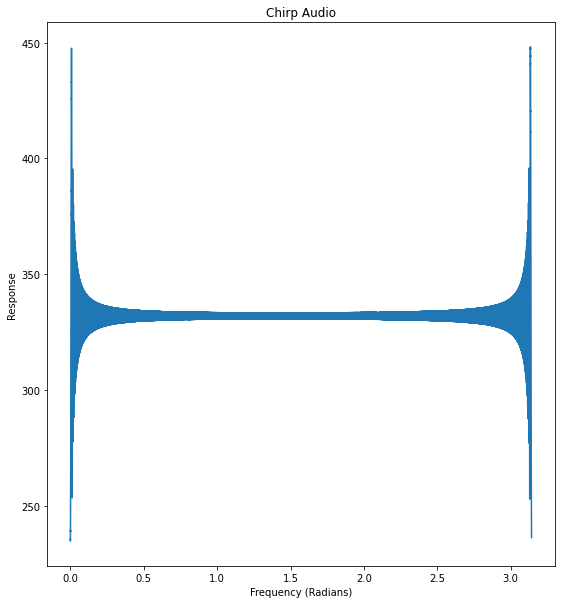

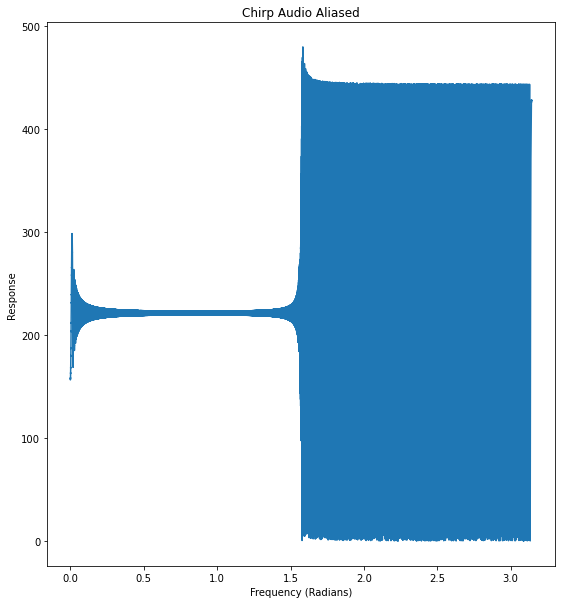

In [80]:
#Code for 5.a here:
f = np.linspace(0, np.pi, len(chirp_original), endpoint=False)

chirpFFT = np.fft.rfft(chirp_original, len(chirp_original)*2 - 1)
plt.figure(figsize = (20,10))
plt.subplot(121)
plt.title('Chirp Audio')
plt.xlabel('Frequency (Radians)')
plt.ylabel('Response')
plt.plot(f, np.absolute(chirpFFT))

#Code for 5.b here:
Fs = 29400 #sampling rate for audio clip in Hz
t1 = 5 #make clips 5 seconds
t = np.linspace(0,t1,t1*Fs) #make sure to specify the number of points to match desired sampling frequency!!!
f0 = 0 #start frequency (Hz)
f1 = 22050 #end frequency (Hz)
chirpAliased = signal.chirp(t, f0 = f0, t1 = t1, f1 = f1)
Audio(data = chirpAliased, rate = Fs)
f2 = np.linspace(0, np.pi, len(chirpAliased), endpoint=False)
chirpFFT2 = np.fft.rfft(chirpAliased, len(chirpAliased)*2 - 1)

plt.figure(figsize = (20,10))
plt.subplot(122)
plt.title('Chirp Audio Aliased')
plt.xlabel('Frequency (Radians)')
plt.ylabel('Response')
plt.plot(f2, np.absolute(chirpFFT2))

current_fs = 29400 #sampling rate for audio clip in Hz
t1 = 5 #make clips 5 seconds
t = np.linspace(0,t1,t1*Fs) #make sure to specify the number of points to match desired sampling frequency!!!
f0 = 0 #start frequency (Hz)
f1 = 22050 #end frequency (Hz)
current_chirp = signal.chirp(t, f0 = f0, t1 = t1, f1 = f1)


In [81]:
#Code cell to listen to different chirps you generate
Audio(data = current_chirp,rate = current_fs) #Remember to use correct sampling frequency!

Answers for 5.a: The max frequency that our sound card can represent is 22,050 Hz. 

Answers for 5.b: It rises to a really high pitch really fast then drops to a slightly lower pitch. You can see this in the beginning part of the DTFT for the aliased signal (from 0.0 -> 0.4).

Answers for 5.c: To get 3 rises and 2 falls, I think you would have to alias the signal more. I am not sure how to find the frequency.


## Submission Instructions

Please rename this notebook to "netid_Lab3" and submit a zip file including all the supplied files for this lab to Compass. Please also name your zip file submission "netid_Lab3".